In [4]:
from PIL import Image
import torchvision.transforms as transforms
from torch import nn as nn
from torch.nn.init import xavier_uniform_, zeros_
from torchvision.models.resnet import conv1x1, conv3x3, resnet18
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import selectivesearch
import numpy as np
import cv2
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import json
import os
import sys




%matplotlib inline

In [5]:
img = load_img("resources/dog1.jpg")
fts = rgb2hsv(img)

In [ ]:
plt.imshow(fts.T)

In [12]:
nb_clusters = 10
labels, cluster_centers = cluster_ft_map(fts, nb_clusters)

In [13]:
labels

array([[0, 4, 4, ..., 6, 6, 6],
       [0, 4, 4, ..., 6, 6, 6],
       [0, 4, 4, ..., 6, 6, 6],
       ...,
       [3, 3, 3, ..., 3, 3, 1],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

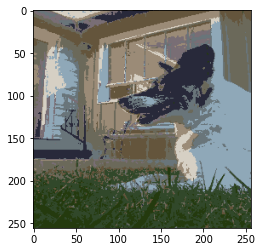

In [14]:
clustered_img = cluster_centers[labels].astype(np.uint8)
rgb_clustered_img = np.array(Image.fromarray(clustered_img, mode = 'HSV').convert('RGB'))
plt.imshow(rgb_clustered_img)

In [15]:
import random

def draw_contours(img, nb_clusters, labels):
    for k in range(nb_clusters):
        cluster_images = np.where(labels==k, 255, 0)
        cluster_images = np.stack([cluster_images for i in range(3)], axis = -1).astype(np.uint8)
        imgray = cv2.cvtColor(cluster_images, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 127, 255, 0)
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contours_poly = [None]*len(contours)
        boundRect = [None]*len(contours)
        c = max(contours, key = cv2.contourArea)

        contours_poly = cv2.approxPolyDP(c, 3, True)
        boundRect = cv2.boundingRect(contours_poly)

        cv2.rectangle(rgb_clustered_img, (int(boundRect[0]), int(boundRect[1])), \
              (int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])), color, 2)

        """for i, c in enumerate(contours):
            c = max(contours, key = cv2.contourArea)

            contours_poly[i] = cv2.approxPolyDP(c, 3, True)
            boundRect[i] = cv2.boundingRect(contours_poly[i])


        for i in range(len(contours)):
            cv2.rectangle(rgb_clustered_img, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)"""


    cv2.imshow('Contours', rgb_clustered_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #plt.imshow(rgb_clustered_img)

In [16]:
draw_contours(img, nb_clusters, labels)

In [1]:
def rgb2hsv(img):
    return torch.tensor(np.transpose(img.convert('HSV'), axes=[2, 0, 1]))  # c x h x w


In [2]:
def load_img(path):
    return Image.open(path).resize((256, 256))


In [3]:
def cluster_ft_map(features, num_clusters):
    c, h, w = features.shape
    features = features.reshape(c, h * w).permute(1, 0).numpy()
    kmeans = KMeans(n_clusters=num_clusters).fit(features)
    #sil_score = silhouette_score(features, kmeans.labels_, metric='euclidean')
    labels = kmeans.labels_.reshape((h, w))
    cluster_centers = kmeans.cluster_centers_
    return labels, cluster_centers #, sil_score